# Очистка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sber_data = pd.read_csv('data/sber_data.csv')
sber_data['sub_area'].nunique()
sber_data['price_doc'].max()



111111112

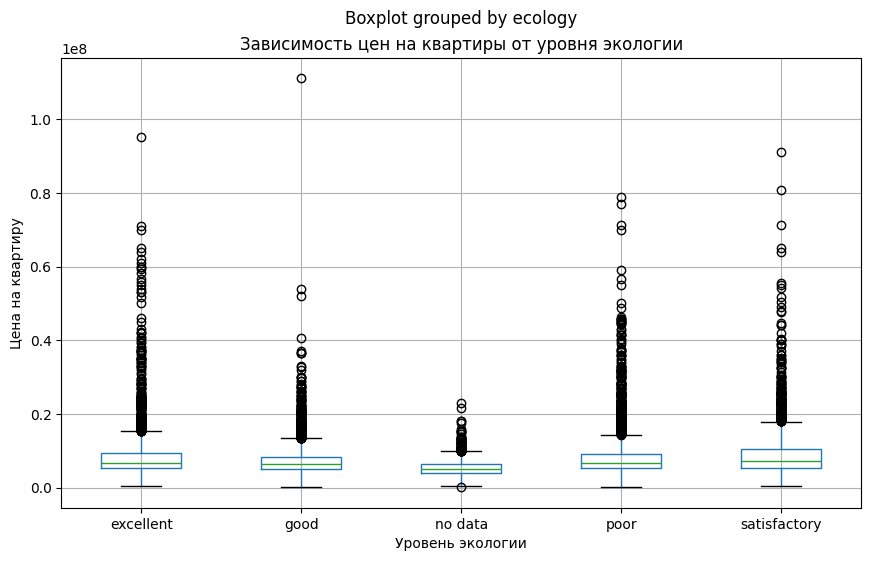

In [3]:
sber_data.boxplot(column='price_doc', by='ecology', figsize=(10, 6))
plt.title('Зависимость цен на квартиры от уровня экологии')
plt.xlabel('Уровень экологии')
plt.ylabel('Цена на квартиру')
plt.show()

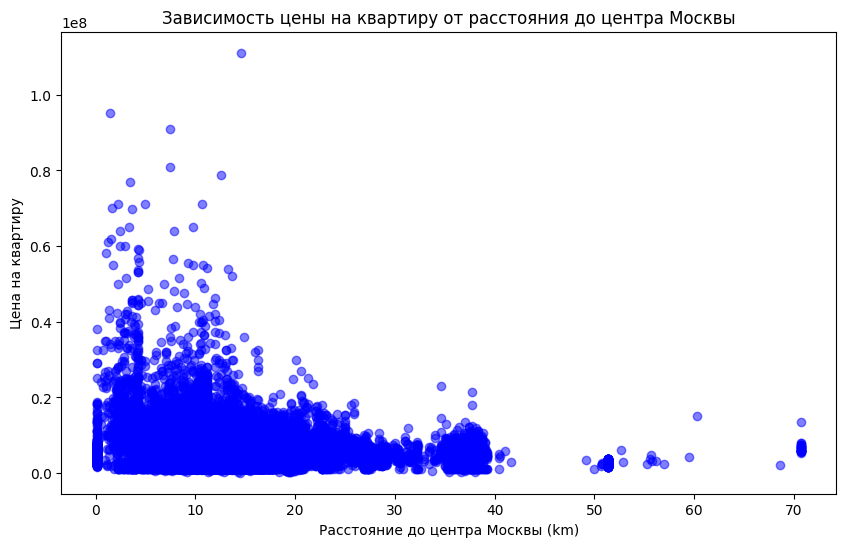

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(sber_data['kremlin_km'], sber_data['price_doc'], color='blue', alpha=0.5)
plt.title('Зависимость цены на квартиру от расстояния до центра Москвы')
plt.xlabel('Расстояние до центра Москвы (km)')
plt.ylabel('Цена на квартиру')
plt.show()

hospital_beds_raion          47.392603
preschool_quota              21.948738
school_quota                 21.938893
life_sq                      20.947786
floor                         0.548062
metro_min_walk                0.082045
metro_km_walk                 0.082045
railroad_station_walk_km      0.082045
railroad_station_walk_min     0.082045
dtype: float64

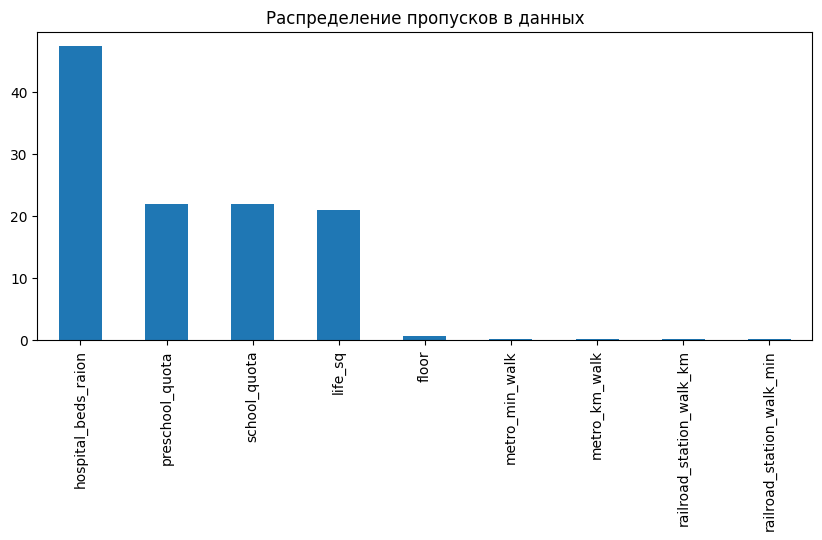

In [5]:
# Для этого вычислим средний по столбцам результат метода isnull(). Получим долю пропусков в каждом столбце.
cols_null_percent = sber_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

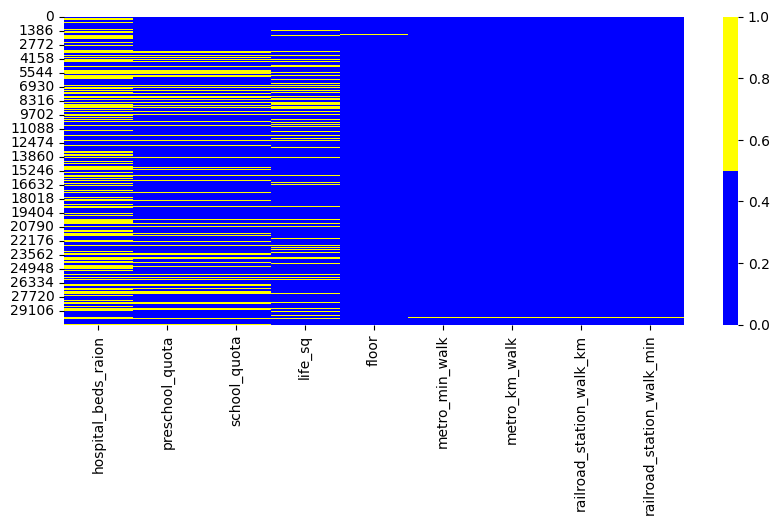

In [6]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    sber_data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

In [7]:
#создаём копию исходной таблицы
combine_data = sber_data.copy()

#отбрасываем столбцы с числом пропусков более 30% (100-70)
n = combine_data.shape[0] #число строк в таблице
thresh = n*0.7
combine_data = combine_data.dropna(thresh=thresh, axis=1)

#отбрасываем строки с числом пропусков более 2 в строке
m = combine_data.shape[1] #число признаков после удаления столбцов
combine_data = combine_data.dropna(thresh=m-2, axis=0)

#создаём словарь 'имя_столбца': число (признак), на который надо заменить пропуски 
values = {
    'life_sq': combine_data['full_sq'],
    'metro_min_walk': combine_data['metro_min_walk'].median(),
    'metro_km_walk': combine_data['metro_km_walk'].median(),
    'railroad_station_walk_km': combine_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': combine_data['railroad_station_walk_min'].median(),
    'preschool_quota': combine_data['preschool_quota'].mode()[0],
    'school_quota': combine_data['school_quota'].mode()[0],
    'floor': combine_data['floor'].mode()[0]
}
#заполняем оставшиеся записи константами в соответствии со словарем values
combine_data = combine_data.fillna(values)
#выводим результирующую долю пропусков
display(combine_data.isnull().mean())
print(combine_data.shape)

id                                       0.0
full_sq                                  0.0
life_sq                                  0.0
floor                                    0.0
sub_area                                 0.0
preschool_quota                          0.0
preschool_education_centers_raion        0.0
school_quota                             0.0
school_education_centers_raion           0.0
school_education_centers_top_20_raion    0.0
healthcare_centers_raion                 0.0
university_top_20_raion                  0.0
sport_objects_raion                      0.0
additional_education_raion               0.0
culture_objects_top_25_raion             0.0
shopping_centers_raion                   0.0
office_raion                             0.0
oil_chemistry_raion                      0.0
railroad_terminal_raion                  0.0
nuclear_reactor_raion                    0.0
metro_min_avto                           0.0
metro_km_avto                            0.0
metro_min_

(26800, 60)


In [8]:
outliers = sber_data[sber_data['life_sq'] > sber_data['full_sq']] # смотрим выбросы где жилая площадь больше чем полная 
print(outliers.shape[0])

cleaned = sber_data.drop(outliers.index, axis=0) # удаляем так как это невозможно
print(f'Результирующее число записей: {cleaned.shape[0]}')

37
Результирующее число записей: 30434


# Выбросы

In [9]:
# Метод тьюки
#  вычислить 25-ый и 75-ый квантили (первый и третий квартили) 
# вычислить межквартильное расстояние: IQR = Q75 - Q25
# вычислить верхнюю границу lower_bound = Q25 - (iqr * 1.5)
# вычислить нижнюю границу upper_bound = Q75 - (iqr * 1.5)
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [10]:
outliers, cleaned = outliers_iqr(sber_data, 'full_sq')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 963
Результирующее число записей: 29508


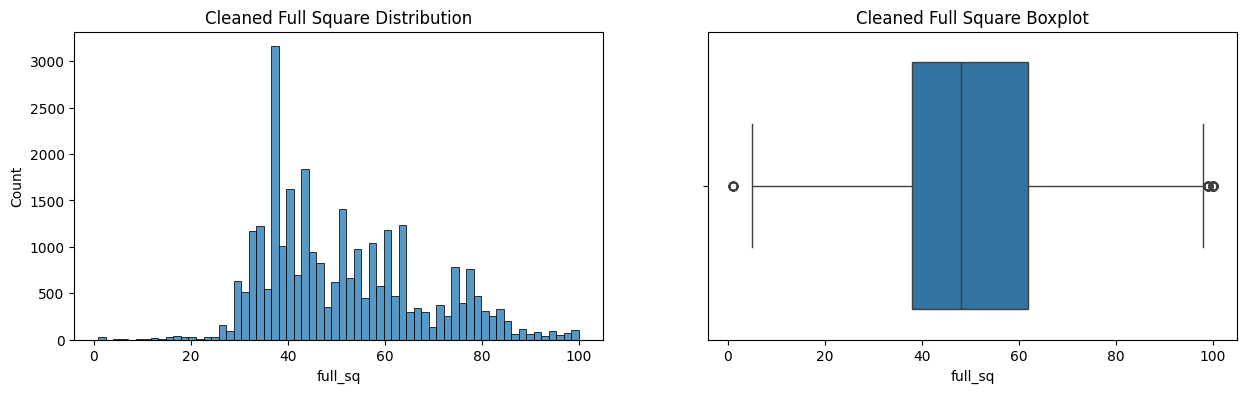

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

In [27]:
def outliers_iqr_mod(data, feature, log_scale=False, left=1.5, right=1.5):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(data=sber_data, feature='full_sq', left=1, right=6)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 59
Результирующее число записей: 30412


# Метод Z - отклонгений (метод Сигм)
логарифимрование если функция +- логнормальная 

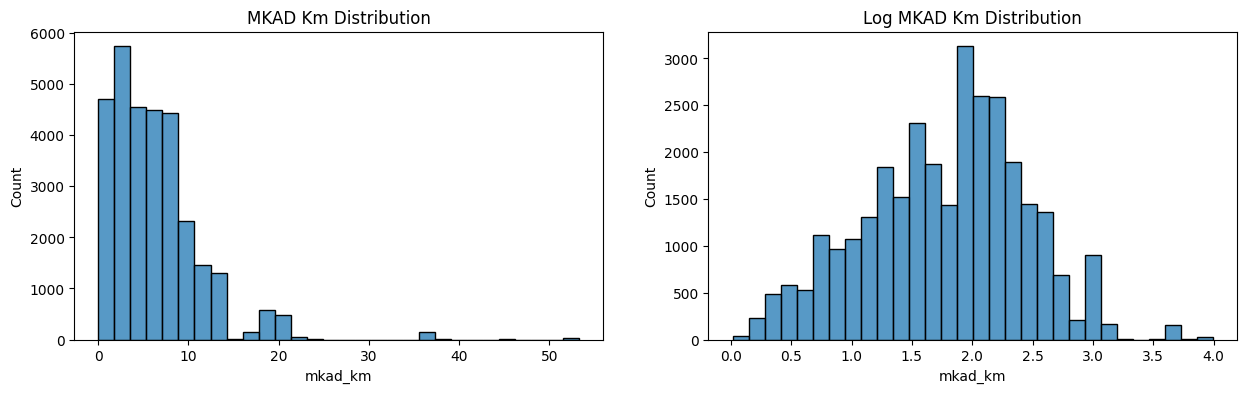

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution');

In [19]:
# Если распределение логнормальное то логарифмируем его для нормального
# Вычислим мат ожидание и стандартное отклонение 
# Вычислим границы
# найдем то что выходит за границы 
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [20]:
outliers, cleaned = outliers_z_score(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 33
Результирующее число записей: 30438


In [21]:
import numpy as np

def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned  


outliers, cleaned = outliers_z_score_mod(sber_data, 'mkad_km', log_scale=True, left=3, right=3.5)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 0
Результирующее число записей: 30471


-0.6867147547476372


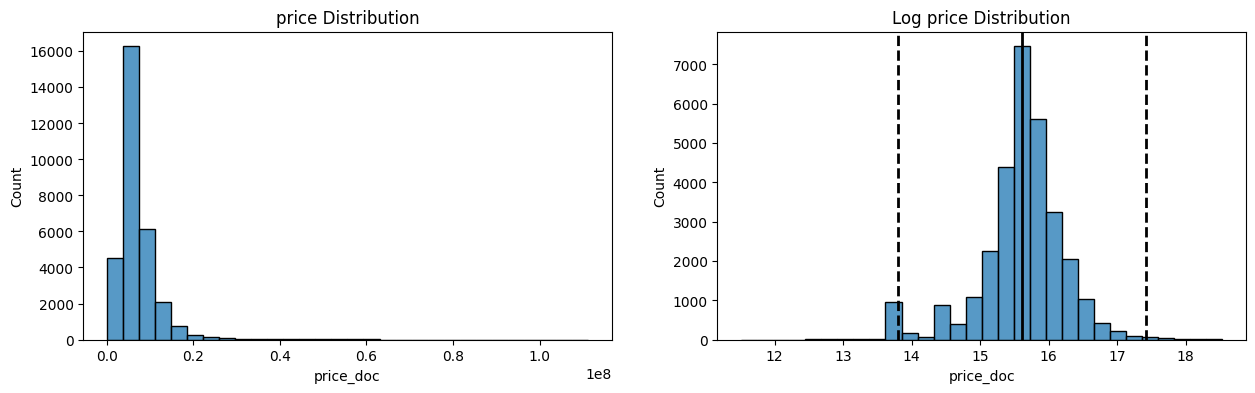

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['price_doc'], bins=30, ax=axes[0])
histplot.set_title('price Distribution');

#гистограмма в логарифмическом масштабе
log_price= np.log(sber_data['price_doc'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.axvline(log_price.mean(), color='k', lw=2)
histplot.axvline(log_price.mean()+ 3 * log_price.std(), color='k', ls='--', lw=2)
histplot.axvline(log_price.mean()- 3 * log_price.std(), color='k', ls='--', lw=2)
histplot.set_title('Log price Distribution');

print(log_price.skew())

In [25]:
outliers, cleaned = outliers_z_score_mod(sber_data, 'price_doc', log_scale=True, left=3.7, right=3.7)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 52
Результирующее число записей: 30419


In [30]:
outliers, cleaned = outliers_iqr_mod(data=sber_data, feature='price_doc',log_scale=True ,left=3, right=3)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 92
Результирующее число записей: 30379


# Дубликаты

In [31]:
dupl_columns = list(sber_data.columns)
dupl_columns.remove('id')

mask = sber_data.duplicated(subset=dupl_columns)
sber_duplicates = sber_data[mask]
print(f'Число найденных дубликатов: {sber_duplicates.shape[0]}')

Число найденных дубликатов: 562


In [32]:
sber_dedupped = sber_data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

Результирующее число записей: 29909


In [33]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in sber_data.columns:
    #наибольшая относительная частота в признаке
    top_freq = sber_data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = sber_data[col].nunique() / sber_data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

id: 100.0% уникальных значений
oil_chemistry_raion: 99.03% одинаковых значений
railroad_terminal_raion: 96.27% одинаковых значений
nuclear_reactor_raion: 97.17% одинаковых значений
big_road1_1line: 97.44% одинаковых значений
mosque_count_1000: 98.08% одинаковых значений


In [34]:
information_sber_data = sber_data.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {information_sber_data.shape[1]}')

Результирующее число признаков: 55
